In [2]:
import os
import pandas as pd
import numpy as np

# Read the two above datasets into pandas

df_sentiment = pd.read_csv('dataset/combined_dataset/sentiment_dataset.csv')


In [3]:
df_sentiment.head()

unique_id  customer_id  local_guide  date_year  \
0          0          394         True       2023   
1          1          604         True       2022   
2          2          528         True       2023   
3          3          591         True       2024   
4          4          336        False       2023   

                                                text              store_name  \
0  This store has cool merchandise. Very stylish ...  Berlin Store Originals   
1  very friendly kind people. they helped me and ...  Berlin Store Originals   
2  Was keen to visit hoping to find some German b...  Berlin Store Originals   
3  Lots of different choices ive never seen befor...  Berlin Store Originals   
4  The person on a cash register didn’t answer my...  Berlin Store Originals   

  company_name text_response label_name  confidence_score  label_id  
0       adidas           NaN   positive          0.963334         1  
1       adidas           NaN   positive          0.883232         1  
2       adidas           NaN    neutral          0.454984         0  
3       adidas           NaN   positive          0.404322         1  
4       adidas           NaN    neutral          0.466237         0

In [4]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", verbose=True)

topics, probs = topic_model.fit_transform(df_sentiment.text)

docs = df_sentiment.text.tolist()

topic_model.visualize_documents(docs)

2024-03-23 13:26:31,875 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/214 [00:00<?, ?it/s]

2024-03-23 13:26:40,948 - BERTopic - Embedding - Completed ✓
2024-03-23 13:26:40,949 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-23 13:27:04,712 - BERTopic - Dimensionality - Completed ✓
2024-03-23 13:27:04,713 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-23 13:27:04,965 - BERTopic - Cluster - Completed ✓
2024-03-23 13:27:04,971 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-23 13:27:05,225 - BERTopic - Representation - Completed ✓


## Few things we notice:
* There are many clusters that are just the same one or two words. 
    * Let's remove reviews shorter than 3 words.
* There are too many clusters for the model to be interpretable.
    * We will tune the hyperparamters of each model and upgrade the embedding model. 
* The data from adidas and the competitor mix in and create uniterpretable clusters.
    * We will split the adidas data and only cluster it, to understand our reviews first.


* The clusters have names that are not easy to understand
    * We are going to upgrade the representation model to use KeyBERT and LLMs
* Reviews with positive and negative sentiment are getting mixed up in the same cluster.
    * We can split the data by sentiment and cluster it in that form.
    * This will give us titles of the clusters which will also indicate the sentiment.
    * Ex. instead of getting a cluster `Customer Service` we could get clusters `Good Customer Service` and `Bad Customer Service`.

In [5]:
# Remove the texts that are shorted than 3 words

df_sentiment['text'] = df_sentiment['text'].apply(lambda x: x if len(x.split()) > 3 else None)
df_sentiment = df_sentiment.dropna(subset=['text'])

# Take only data where company_name is adidas
df_sentiment = df_sentiment[df_sentiment['company_name'] == 'adidas']
df_sentiment


unique_id  customer_id  local_guide  date_year  \
0             0          394         True       2023   
1             1          604         True       2022   
2             2          528         True       2023   
3             3          591         True       2024   
4             4          336        False       2023   
...         ...          ...          ...        ...   
6813        258          199         True       2018   
6815        260          211        False       2019   
6818        263          248         True       2019   
6820        265           57        False       2023   
6825        270          240         True       2018   

                                                   text  \
0     This store has cool merchandise. Very stylish ...   
1     very friendly kind people. they helped me and ...   
2     Was keen to visit hoping to find some German b...   
3     Lots of different choices ive never seen befor...   
4     The person on a cash register didn’t answer my...   
...                                                 ...   
6813                          Adidas is a great guy😍❤ …   
6815                         Good sports clothing store   
6818       Somewhat sparse selection of Adidas products   
6820                                            👍 👍 👍 …   
6825                  Really has everything from Adidas   

                  store_name company_name text_response label_name  \
0     Berlin Store Originals       adidas           NaN   positive   
1     Berlin Store Originals       adidas           NaN   positive   
2     Berlin Store Originals       adidas           NaN    neutral   
3     Berlin Store Originals       adidas           NaN   positive   
4     Berlin Store Originals       adidas           NaN    neutral   
...                      ...          ...           ...        ...   
6813         Nuremberg Store       adidas           NaN   positive   
6815         Nuremberg Store       adidas           NaN   positive   
6818         Nuremberg Store       adidas           NaN   positive   
6820         Nuremberg Store       adidas           NaN   negative   
6825         Nuremberg Store       adidas           NaN   positive   

      confidence_score  label_id  
0             0.963334         1  
1             0.883232         1  
2             0.454984         0  
3             0.404322         1  
4             0.466237         0  
...                ...       ...  
6813          0.938314         1  
6815          0.932384         1  
6818          0.444108         1  
6820          0.377492        -1  
6825          0.493397         1  

[4097 rows x 11 columns]

In [6]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance


# Let's split the original dataset into positive, negative and neutral sentiment
# Then cluster each of them separately

df_sentiment_positive = df_sentiment[df_sentiment.label_name == 'positive']
df_sentiment_negative = df_sentiment[df_sentiment.label_name == 'negative']
df_sentiment_neutral = df_sentiment[df_sentiment.label_name == 'neutral']


# construct a dictionary

sentiment_dict = {
    'positive': {'df': df_sentiment_positive, 'name': 'positive'},
    'negative': {'df': df_sentiment_negative, 'name': 'negative'},
    'neutral': {'df': df_sentiment_neutral, 'name': 'neutral'}
}

# Extract all embeddings and put them in the dict

for sentiment in sentiment_dict:
    df = sentiment_dict[sentiment]['df']
    docs = df.text.to_list()
    sentence_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
    embeddings = sentence_model.encode(docs, show_progress_bar=True)
    sentiment_dict[sentiment]['embeddings'] = embeddings
    

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# Defining each part of the BERTopic model

sentence_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

umap_config_dict = {
    'n_neighbors': 20,
    'n_components': 2,
    'metric': 'cosine',
    'random_state': 42,
}
hdbscan_config = {
    'min_cluster_size': 15,
    'metric': 'euclidean',
    'cluster_selection_method': 'leaf',
    'min_samples': 15,
    'cluster_selection_epsilon': 0.1,
} 

# Initialize UMAP with the given configuration 
umap_model = UMAP(**umap_config_dict)

# Initialize HDBSCAN with the given configuration
hdbscan_model = HDBSCAN(**hdbscan_config)

# Define the representation models
main_representation  = KeyBERTInspired(top_n_words=10, nr_repr_docs = 10)
representation_model = [KeyBERTInspired(top_n_words=30, nr_repr_docs = 10), MaximalMarginalRelevance(diversity=0.3,top_n_words=10)]


# Store the models in a dictionary
representation_models = {
    "Main" : main_representation,
    "KeyBert+MMR": representation_model,
}


In [8]:
from bertopic import BERTopic

for sentiment in sentiment_dict:
    
    print("Working on sentiment: ", sentiment)
    df = sentiment_dict[sentiment]['df']

    docs = df.text.to_list()

    embeddings = sentiment_dict[sentiment]['embeddings']

    # Initialize the topic model
    topic_model = BERTopic(
        embedding_model=sentence_model,
        umap_model=umap_model,
        hdbscan_model= hdbscan_model,
        representation_model=representation_models,
        verbose=True,
    )

    # Fit the topic model
    topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

    # Save the topic model in the dict
    sentiment_dict[sentiment]['topic_model'] = topic_model
    sentiment_dict[sentiment]['docs'] = docs



2024-03-23 13:27:50,796 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Working on sentiment:  positive


2024-03-23 13:28:09,961 - BERTopic - Dimensionality - Completed ✓
2024-03-23 13:28:09,962 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-23 13:28:10,012 - BERTopic - Cluster - Completed ✓
2024-03-23 13:28:10,015 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-23 13:28:16,517 - BERTopic - Representation - Completed ✓
2024-03-23 13:28:16,607 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Working on sentiment:  negative


2024-03-23 13:28:19,755 - BERTopic - Dimensionality - Completed ✓
2024-03-23 13:28:19,756 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-23 13:28:19,769 - BERTopic - Cluster - Completed ✓
2024-03-23 13:28:19,772 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-23 13:28:23,937 - BERTopic - Representation - Completed ✓
2024-03-23 13:28:23,986 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Working on sentiment:  neutral


2024-03-23 13:28:25,207 - BERTopic - Dimensionality - Completed ✓
2024-03-23 13:28:25,208 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-23 13:28:25,214 - BERTopic - Cluster - Completed ✓
2024-03-23 13:28:25,216 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-23 13:28:27,039 - BERTopic - Representation - Completed ✓


In [15]:
sentiment = 'positive'
#sentiment = 'negative'
#sentiment = 'neutral'

sentiment_dict[sentiment]['topic_model'].get_topic_info().iloc[1:6]

Topic  Count                                        Name  \
1      0     98          0_bargains_bargain_discounts_deals   
2      1     94             1_outlet_bargains_bargain_store   
3      2     93  2_friendliness_friendly_helping_friendlier   
4      3     78          3_shopping_store_customer_friendly   
5      4     78          4_adidas_sportswear_apparels_shoes   

                                      Representation  \
1  [bargains, bargain, discounts, deals, discount...   
2  [outlet, bargains, bargain, store, offers, ava...   
3  [friendliness, friendly, helping, friendlier, ...   
4  [shopping, store, customer, friendly, service,...   
5  [adidas, sportswear, apparels, shoes, discount...   

                                         KeyBert+MMR  \
1  [bargains, bargain, discounts, deals, discount...   
2  [outlet, bargains, bargain, store, offers, ava...   
3  [friendliness, friendly, friendlier, employees...   
4  [shopping, store, customer, friendly, service,...   
5  [adidas, sportswear, apparels, shoes, discount...   

                                 Representative_Docs  
1  [You can get good bargains, You can get good b...  
2  [Very large outlet.\nWith a great selection!!!...  
3  [The staff is very friendly and competent., Th...  
4  [Nice store. Staff very friendly and competent...  
5  [Finally, a good Adidas outlet where you can a...

In [16]:

sentiment_dict[sentiment]['topic_model'].visualize_documents(sentiment_dict[sentiment]['docs'])

In [17]:
# Visualize Hierarchical Topics with a slider to adjust the number of topics

# Calculate hierarchical topics
hierarchical_topics = sentiment_dict[sentiment]['topic_model'].hierarchical_topics(sentiment_dict[sentiment]['docs'])

# Vizualization
sentiment_dict[sentiment]['topic_model'].visualize_hierarchical_documents(sentiment_dict[sentiment]['docs'], hierarchical_topics, hide_document_hover = False)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


In [22]:
#sentiment = 'positive'
sentiment = 'negative'
#sentiment = 'neutral'

sentiment_dict[sentiment]['topic_model'].get_topic_info().iloc[1:6]

Topic  Count                                       Name  \
1      0     70  0_unfriendly_complaint_customer_customers   
2      1     47                   1_adidas_shoes_shoe_nike   
3      2     46          2_adidas_retailers_clothing_shoes   
4      3     38                        3_sizes_xxl_xl_size   
5      4     35        4_bargains_expensive_discounts_lots   

                                      Representation  \
1  [unfriendly, complaint, customer, customers, r...   
2  [adidas, shoes, shoe, nike, wearing, broke, us...   
3  [adidas, retailers, clothing, shoes, outlet, b...   
4  [sizes, xxl, xl, size, clothing, shirts, xs, l...   
5  [bargains, expensive, discounts, lots, assortm...   

                                         KeyBert+MMR  \
1  [unfriendly, complaint, customer, customers, r...   
2  [adidas, shoes, nike, wearing, used, jerseys, ...   
3  [adidas, retailers, clothing, shoes, brand, us...   
4  [sizes, xxl, xl, size, clothing, shirts, large...   
5  [bargains, expensive, discounts, lots, assortm...   

                                 Representative_Docs  
1  [The clerk at the checkout was unable to prope...  
2  [Unfortunately, adidas products are no longer ...  
3  [Although it is at the core of Adidas in the w...  
4  [The selection is very large. Unfortunately, T...  
5  [Large outlet, large selection, but confusing....

In [23]:
# Visualize the topics for the negative sentiment
sentiment_dict[sentiment]['topic_model'].visualize_documents(sentiment_dict[sentiment]['docs'])

In [28]:
# Visualize the topics over time and look at the trends

topics_over_time = sentiment_dict[sentiment]['topic_model'].topics_over_time(sentiment_dict[sentiment]['docs'],
                                                                            sentiment_dict[sentiment]['df'].date_year.to_list(),
                                                                            nr_bins=15)
sentiment_dict[sentiment]['topic_model'].visualize_topics_over_time(topics_over_time, top_n_topics=15)

11it [00:18,  1.67s/it]


In [29]:
def create_representative_docs_list(topic_model, documents,  max_docs=10):
    """
    Create a representative document list based on topics and a list of probabilities.

    Args:
        topic_model (BERTopic): The BERTopic model used to extract the topics and probabilities.
        documents (list): List of documents.
        max_docs (int): Maximum number of representative documents to extract per topic.
    Returns:
        dict: Dictionary of representative documents.
    """
    
    
    probs = topic_model.probabilities_
    topics = topic_model.topics_
    
    documents_df = pd.DataFrame({
          "Document": documents,
          "Topic": topics,
          "Probs":probs})

    repr_docs_dict = {}
    
    for topic_name, topic_group in documents_df.groupby('Topic'):
        # Getting the indices of the documents within the current topic group
        topic_indices = topic_group.index
        
        
        # Extracting the probabilities for the documents in the current topic group
        topic_probs = probs[topic_indices]

        # Sorting the indices based on the probabilities in descending order
        sorted_indices = topic_indices[np.argsort(topic_probs)[::-1]]

        # Determining the number of documents to extract, ensuring it doesn't exceed the specified maximum or the available documents in the topic group
        num_docs_to_extract = min(max_docs, len(topic_group))

        # Getting the top N indices based on the sorted probabilities
        top_N_indices = sorted_indices[:num_docs_to_extract]

        # Extracting the text of the top N documents using the top N indices
        top_N_texts = documents_df.loc[top_N_indices, 'Document'].tolist()

        # Storing the representative documents for the current topic in the dictionary
        repr_docs_dict[topic_name] = top_N_texts

    return repr_docs_dict

# create representative documents and print the first one
docs = sentiment_dict[sentiment]['df'].text.to_list()
representative_docs = create_representative_docs_list(sentiment_dict[sentiment]['topic_model'], docs,  max_docs=10)
representative_docs[0]

['Great place, friendly staff, rating is because the staff behind the cafe counter are so grumpy and lack any sort of emotion, it’s like they are forced to be there.  You are in a customer facing role if you don’t like seeing customers maybe you need a different role.  This is not the first time !',
 'Not recommended, unfriendly staff no time to answer questions.',
 'Arrogant staff, very unfriendly and not interested in the customer. Never seen something like that before...',
 "Very unfriendly staff just walk around and care more about themselves than about the guests. Starts with greeting very unfriendly the security guard very aggressive immediately gets a pulse and becomes very personal and private sorry that's …",
 'The service was once very condescending... Not very customer friendly.',
 'No hello, no thank you, no please. Instead, arrogant and unmotivated employees. Never again!',
 'Rude to the point of not being possible anymore!',
 'Really bad service and very disrespectful sta

In [30]:
import os
import openai
from tqdm import tqdm


# Function to load environment variables from a .env file
def load_env_variables(env_file):
    with open(env_file) as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                # Ignore comments and empty lines
                continue
            # Split the line into key and value
            key, value = line.strip().split('=', 1)
            os.environ[key] = value  # Set the environment variable

# Load environment variables
load_env_variables('.env')

# Access the TOKEN environment variable
token = os.getenv('TOKEN')

client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key = token
    )


In [31]:
# Write a function to generate a title for each topic
# It needs use the topic model, generate representative documents and keywords and then pass them to the model
# Also it needs to update the prompt with the representative documents and keywords and then pass it to the model


def generate_topic_title(topic_model, sentiment, max_docs=10):
    """
    Generate a title for each topic based on the representative documents and keywords.

    Args:
        topic_model (BERTopic): The BERTopic model used to generate the topics.
        sentiment (str): The sentiment for which the title is to be generated.
        max_docs (int): The maximum number of representative documents to consider for generating the title.

    Returns:
        str: The title generated for the topic.
    """
    # Extract the documents for the specified sentiment
    docs = sentiment_dict[sentiment]['df'].text.to_list()

    sentiment_dict[sentiment]['titles'] = {}
    sentiment_dict[sentiment]['repr_docs'] = {}
    sentiment_dict[sentiment]['keywords'] = {}
    
    # Create a list of representative documents based on the specified maximum number
    representative_docs = create_representative_docs_list(topic_model, docs, max_docs)

    for topic in tqdm(representative_docs):
        if topic == -1:
            continue
        # Extract the representative documents and keywords for the current topic
        repr_docs_list = representative_docs[topic]
        repr_docs_str = ' '.join(repr_docs_list)

        keywords_list = [x[0] for x in topic_model.get_topic(topic)]
        keywords_str = ', '.join(keywords_list)

        # Construct the prompt for generating the title
        prompt = "I have a task for you! \n\n"
        prompt += "You are a helpful assistant. \n\n"
        prompt += "You are working on a project to categorize customer reviews of Adidas stores based on their content. \n\n"
        prompt += "I need you to generate a short name for the topic. Practically answer the question What are these reivews about? \n\n"
        prompt += "Based on the following representative documents and keywords, write a short topic name that encapsulates the idea of the documents.\
                    Make it short and concrete and not too descriptive. All of the documents are about customer reviews, so dont tell me that\
                    Only tell me the specifics of what are the customer reviews about. \n\n"
        prompt += "Representative Documents: \n"
        prompt += repr_docs_str
        prompt += "\n\nKeywords: \n"
        prompt += keywords_str
        prompt += "\n\nTitle: "
        prompt += "Answer in the format ```<Your Title>```\n\n"
        prompt += "DO NOT give any explanations or descriptions. Just the title. \n\n"

        # Generate the title using the OpenAI API
        chat_completion = client.chat.completions.create(
            model="mistralai/Mixtral-8x7B-Instruct-v0.1",
            messages=[{"role": "system", "content": "You are a helpful assistant."}, 
                    {"role": "user", "content": prompt}],
            temperature=0.1,
        )

        # Extract the generated title from the completion
        title = chat_completion.choices[0].message.content

        # Clean the title by removing the ``` and " at the beginning and end
        title = title.replace('```', '').replace('"', '').strip()

        # save the title in the dict
        sentiment_dict[sentiment]['titles'][topic] = title
        # Save repr_docs and keywords in the dict
        sentiment_dict[sentiment]['repr_docs'][topic] = repr_docs_list
        sentiment_dict[sentiment]['keywords'][topic] = keywords_list

        # print(f"Generated title for topic {topic}, sentiment {sentiment}: {title}")
        # print("Based on these keywords: ", keywords_str)
        # print("Based on these representative documents: ", repr_docs_list)
    return sentiment_dict[sentiment]


# Generate titles for each sentiment

for sentiment in sentiment_dict:
    print("Working on sentiment: ", sentiment)

    sentiment_dict[sentiment] = generate_topic_title(sentiment_dict[sentiment]['topic_model'], sentiment)
    


Working on sentiment:  positive


100%|██████████| 33/33 [01:02<00:00,  1.88s/it]


Working on sentiment:  negative


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Working on sentiment:  neutral


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


In [32]:
sentiment = 'negative'
sentiment_dict[sentiment]['topic_model'].set_topic_labels(sentiment_dict[sentiment]['titles'])


# Visualize the topics with the generated titles
sentiment_dict[sentiment]['topic_model'].visualize_documents(sentiment_dict[sentiment]['docs'], custom_labels=True)

In [38]:
sentiment_dict[sentiment]['topic_model'].visualize_topics_over_time(topics_over_time, top_n_topics=15, custom_labels=True, normalize_frequency=True)

In [21]:
# In the folder dataset/topic_model we will save the pickle file

import pickle

folder_path = 'dataset/topic_model'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save topic model dict for each sentiment
    
for sentiment in sentiment_dict:
    topic_model_dict = sentiment_dict[sentiment]
    file_path = os.path.join(folder_path, f"topic_model_dict_{sentiment}.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(topic_model_dict, f)


In [39]:
# Lets look at all the negative titles
sentiment_dict[sentiment]["titles"]

{0: 'Unfriendly Service Experiences',
 1: 'Deteriorating Quality & Limited Selection in Adidas Products',
 2: 'Inadequate Adidas Store Experience & Limited Selection',
 3: 'Inadequate Size & Clothing Selection',
 4: 'Store Disorganization & Pricing',
 5: 'High Outlet Prices',
 6: 'Adidas & Reebok Outlet Shopping Experience',
 7: 'Experiences with Corona Restrictions at Adidas Store Entrances',
 8: 'Shopping Experience with Discounts & Bargains',
 9: 'Dogs Not Allowed in Adidas Stores',
 10: 'Crowded Shopping Experience',
 11: 'Deteriorating Outlet Experience'}

In [48]:
# Let's find out more about the dog topic and what people are saying about it
print("Keywords: ", sentiment_dict[sentiment]["keywords"][9])

# Show the representative documents for the dog topic
for rep_doc in sentiment_dict[sentiment]["repr_docs"][9]:
    print("-", rep_doc, "\n")

Keywords:  ['pets', 'dog', 'dogs', 'prohibited', 'ban', 'stroller', 'car', 'leave', 'outside', 'allowed']
- No pets (dogs) allowed?!
Sorry adidas! NoGo! (...no reason) 

- Unfortunately dogs are no longer allowed. It's a shame, but there are other options. Unfortunately, for hot days like today, no drinks are offered for sale unless a small Brita drinks dispenser was provided, of course free of charge!! 

- It's sad that there are stores in Germany where I'm not allowed to enter with my dog. Adidas should actually be aware that they don't sell food. 

- A fixture on our return journey from Croatia for around 10 years, always with a dog. Suddenly dogs are no longer allowed.
It was the last time for us! … 

- Unfortunately, dogs are not allowed in. Not particularly customer friendly when you're on vacation and the sun is beating down. 

- Was immediately turned away at the entrance. I have a small dog weighing 3kg. I was therefore refused entry. Sell ​​outdoor clothing and ban dogs. I ca

In [78]:
sentiment = "negative"



# Let's add the repr_docs, keywords, titles, topics  to the dataframes for each sentiment

for sentiment in sentiment_dict:
    df = sentiment_dict[sentiment]['df']
    topic_model = sentiment_dict[sentiment]['topic_model']
    
    # Get the topics and probabilities
    topics =  topic_model.topics_
    
    # Add the topics and probabilities to the dataframe
    df['topic'] = topics

    # Add the titles, repr_docs and keywords to the dataframe
    df['title'] = df['topic'].map(sentiment_dict[sentiment]['titles'])
    df['repr_docs'] = df['topic'].map(sentiment_dict[sentiment]['repr_docs'])
    df['keywords'] = df['topic'].map(sentiment_dict[sentiment]['keywords'])
    
    # Drop the rows where topic == -1
    df = df[df['topic'] != -1]

    # Save the dataframe in the dict
    sentiment_dict[sentiment]['df'] = df


In [82]:
# Check the dataframe for the negative sentiment
sentiment_dict['neutral']['df']


unique_id  customer_id  local_guide  date_year  \
4             4          336        False       2023   
5             5           37         True       2022   
25           25           14        False       2019   
43           43          387         True       2024   
101         101          598         True       2023   
...         ...          ...          ...        ...   
6659        103          123         True       2023   
6698        142           59         True       2017   
6728        172          111         True       2020   
6761        205          208         True       2018   
6768        212          117         True       2019   

                                                   text  \
4     The person on a cash register didn’t answer my...   
5     I wanted to purchase shoes for my son, they di...   
25                  Not so expensive for original shoes   
43               Far too little selection for Flagstore   
101                              The shop was too small   
...                                                 ...   
6659  Only basic goods in the store that aren't even...   
6698  Unfortunately there is only a limited selectio...   
6728                 Top selection, but not much choice   
6761                 What you want usually isn't there.   
6768                        Not too much of a selection   

                  store_name company_name text_response label_name  \
4     Berlin Store Originals       adidas           NaN    neutral   
5     Berlin Store Originals       adidas           NaN    neutral   
25    Berlin Store Originals       adidas           NaN    neutral   
43    Berlin Store Originals       adidas           NaN    neutral   
101   Berlin Store Originals       adidas           NaN    neutral   
...                      ...          ...           ...        ...   
6659         Nuremberg Store       adidas           NaN    neutral   
6698         Nuremberg Store       adidas           NaN    neutral   
6728         Nuremberg Store       adidas           NaN    neutral   
6761         Nuremberg Store       adidas           NaN    neutral   
6768         Nuremberg Store       adidas           NaN    neutral   

      confidence_score  label_id  topic  \
4             0.466237         0      2   
5             0.371558         0      2   
25            0.433526         0      1   
43            0.364191         0      0   
101           0.361166         0      3   
...                ...       ...    ...   
6659          0.463333         0      1   
6698          0.375861         0      2   
6728          0.643680         0      0   
6761          0.423409         0      0   
6768          0.779166         0      0   

                                                  title  \
4       Inadequate Shoe Selection & Purchase Assistance   
5       Inadequate Shoe Selection & Purchase Assistance   
25    Inadequate Adidas Store Experience & Limited S...   
43                         Limited Children's Selection   
101                Store Experience & Limited Selection   
...                                                 ...   
6659  Inadequate Adidas Store Experience & Limited S...   
6698    Inadequate Shoe Selection & Purchase Assistance   
6728                       Limited Children's Selection   
6761                       Limited Children's Selection   
6768                       Limited Children's Selection   

                                              repr_docs  \
4     [Unfortunately there is only a limited selecti...   
5     [Unfortunately there is only a limited selecti...   
25    [Only basic goods in the store that aren't eve...   
43    [Not too much of a selection, There are not ma...   
101   [I didn't find any real bargains there, Not ev...   
...                                                 ...   
6659  [Only basic goods in the store that aren't eve...   
6698  [Unfortunately there is only a limited selecti...   
6728  [Not too much of a s

In [102]:
# Lets go ahead and print the proportion of each topic in the negative sentiment
# Per store

df = sentiment_dict['negative']['df']

# Calculate the proportion of each topic per store
topic_proportion = df.groupby(['store_name', 'title']).size().unstack().fillna(0)
topic_proportion = topic_proportion.div(topic_proportion.sum(axis=1), axis=0)
topic_proportion = topic_proportion.reset_index()


for store in df.store_name.unique():
    print(f"Store: {store}")
    store_df = topic_proportion[topic_proportion['store_name'] == store]
    store_df = store_df.set_index('store_name')
    store_df = store_df.T
    store_df = store_df.sort_values(by=store_df.columns[0], ascending=False)
    print(store_df[0:3])
    print("\n")

Store: Berlin Store Originals
store_name                                          Berlin Store Originals
title                                                                     
Unfriendly Service Experiences                                    0.500000
Inadequate Adidas Store Experience & Limited Se...                0.181818
Deteriorating Quality & Limited Selection in Ad...                0.090909


Store: Frankfurt Store
store_name                                          Frankfurt Store
title                                                              
Unfriendly Service Experiences                             0.461538
Deteriorating Quality & Limited Selection in Ad...         0.192308
Inadequate Adidas Store Experience & Limited Se...         0.192308


Store: Herzo Outlet
store_name                                          Herzo Outlet
title                                                           
Deteriorating Quality & Limited Selection in Ad...      0.142857
High Outlet P

<Figure size 2000x1000 with 0 Axes>

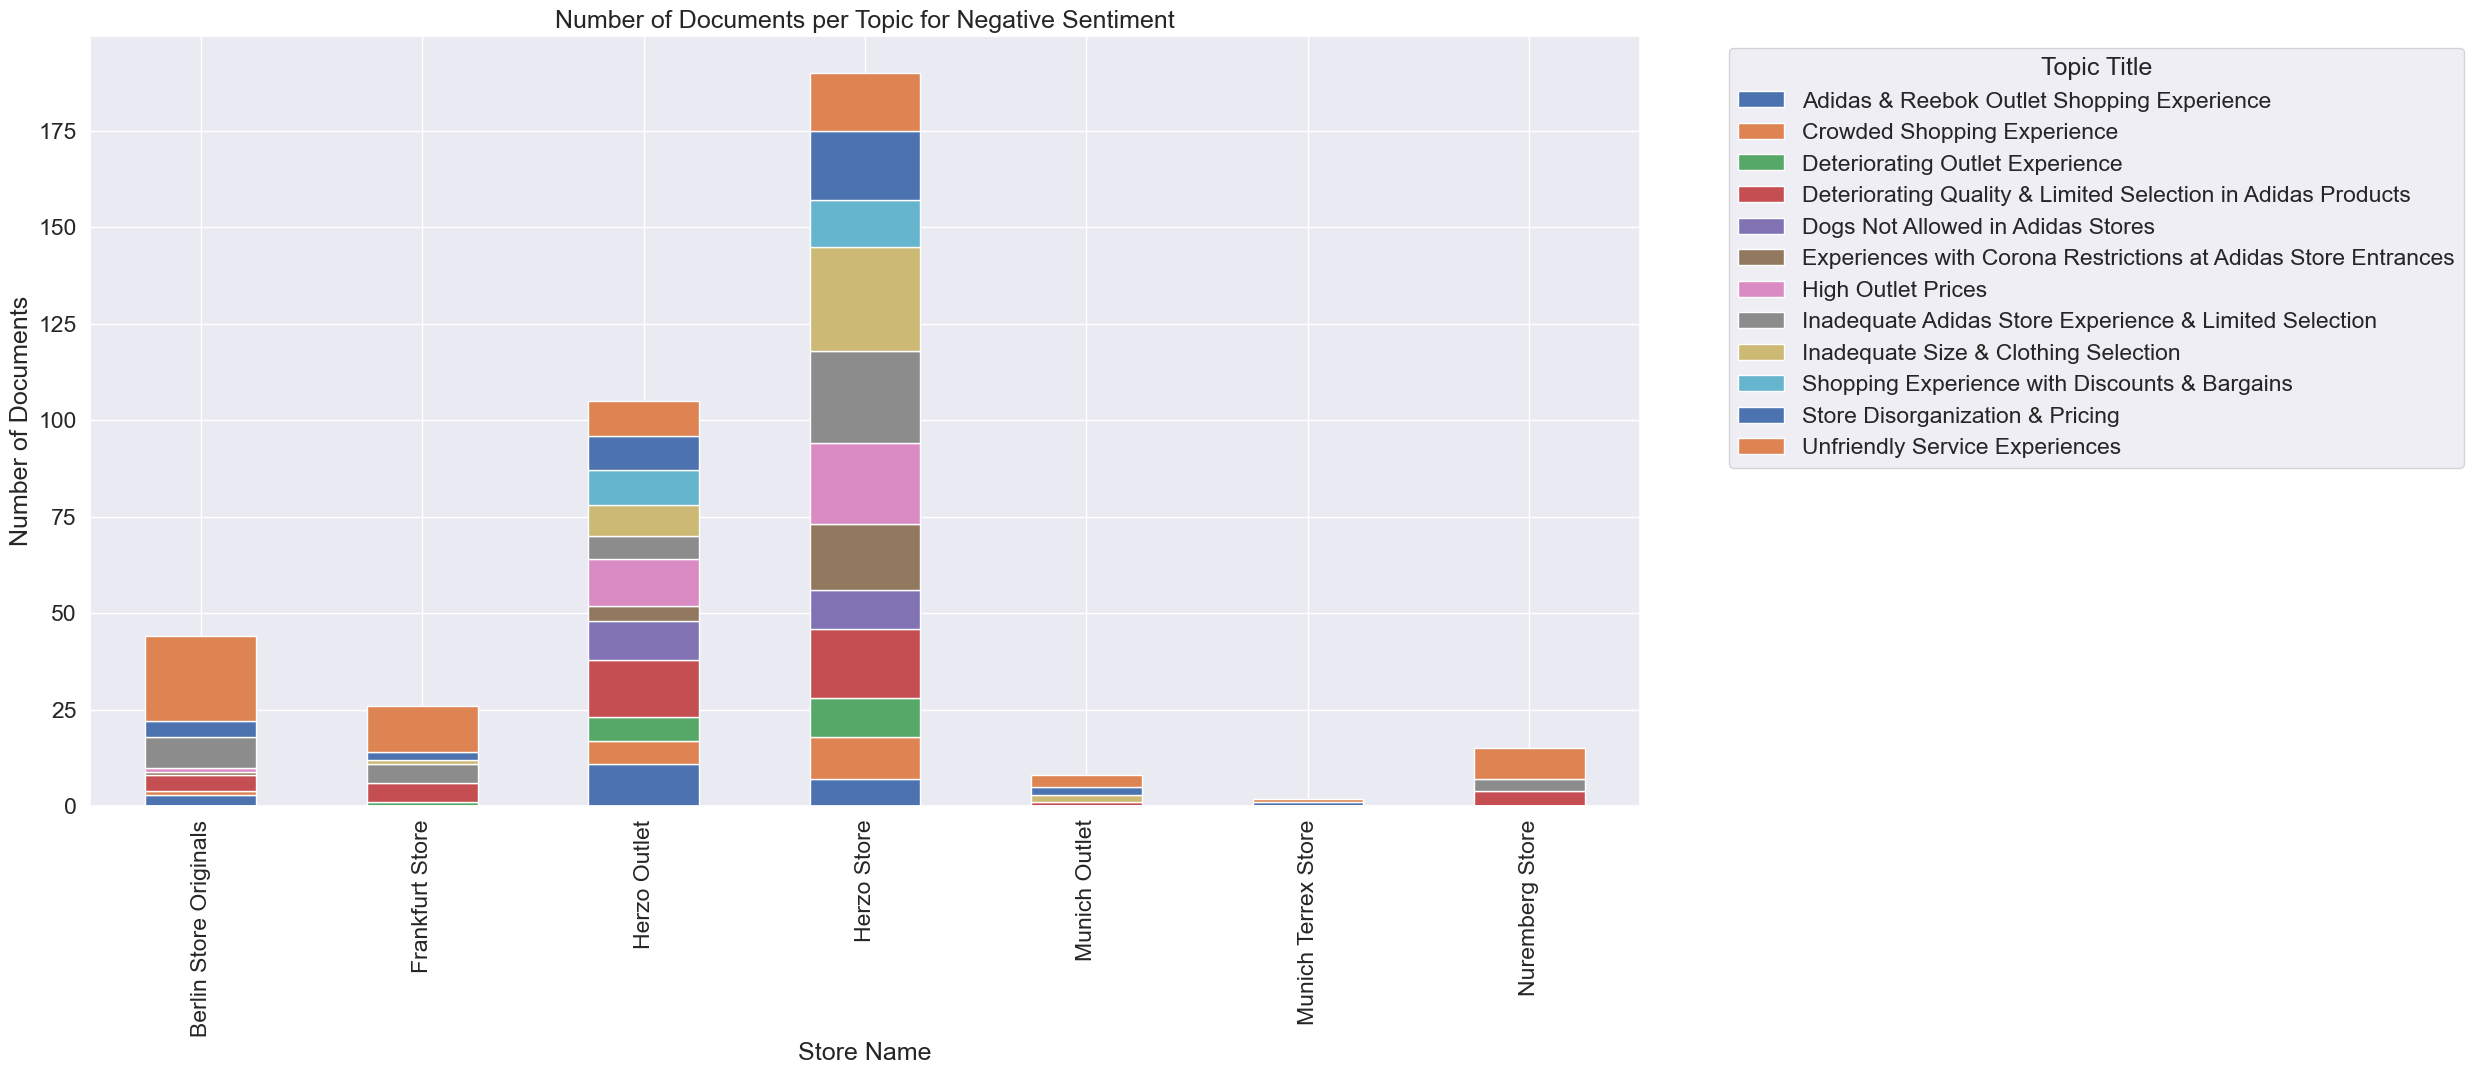

In [91]:
# Lets go over each sentiment and do barcharts for the topics PER store_name

import matplotlib.pyplot as plt
import seaborn as sns

# write a function for it



# Write a function where it will create a single stacked bar chart for each store_name
# Label the x-axis with the stores and the y-axis with the number of documents
# Make sure that the legend has the topic TITLE and the colors are different for each topic


def plot_topics_per_store(df, sentiment):
    """
    Create a single stacked bar chart for each store_name with the number of documents per topic.

    Args:
        df (pd.DataFrame): The dataframe containing the data for the specified sentiment.
        sentiment (str): The sentiment for which the topics are to be plotted.
    """
    
    # Plot all stores on one figure. Make sure that the legend has the topic TITLE and the colors are different for each topic
    # Make sure to use the topic TITLE in the legend
    plt.figure(figsize=(20, 10))
    sns.set_palette("husl")
    sns.set_style("whitegrid")
    sns.set_context("talk")
    sns.set(font_scale = 1.5)

    # Group the data by store_name and topic
    grouped_df = df.groupby(['store_name', 'title']).size().unstack().fillna(0)

    # Plot the stacked bar chart
    grouped_df.plot(kind='bar', stacked=True, figsize=(20, 10))
    plt.xlabel('Store Name')
    plt.ylabel('Number of Documents')
    plt.title(f"Number of Documents per Topic for {sentiment.capitalize()} Sentiment")
    plt.legend(title='Topic Title', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    

# Plot the topics per store for each sentiment
sentiment = 'negative'

plot_topics_per_store(sentiment_dict[sentiment]['df'], sentiment)


In [73]:
docs

['I was in the store on December 1st when there was an event, and I received a bottle as a gift. My friend got a keychain and a 20% voucher. Then, I bought a pair of shoes using the discount. …',
 'The store is very nice and innovative!! I love the store light that it feels really natural with the plants in the store. The staffs are friendly and very knowledgeable!!! Nice selection of out door clothes! I got told that Terrex Thursday takes placed every Thursday evening. I will have to join it once!',
 'The good store for premium Adidas products. I was looking for shoe. There are so many including the new model sport shoes. Recommend!!!',
 'The attention of the staff is incredible, they treated me more than better and I only went to pick up an order, but the attention was more than wonderful. Thank you very much for the kindness. Plus the store is also very modern 😃 …',
 'Very friendly and professional service! Thank you Daria!',
 'Service is very good they have Kunden Beratern that spe